In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from func import AdstockGeometric, Report, Data
import shap
from lightgbm import LGBMRegressor

plt.style.use('fivethirtyeight')

C:\Users\Kevin\miniconda3\envs\py311\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Kevin\miniconda3\envs\py311\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\Kevin\miniconda3\envs\py311\Lib\site-packages\shap\utils\_clustering.py:62: NumbaDe

In [2]:
# Data: Ads
path = Path.home() / 'OneDrive - Seagroup/mkt/mkt_mix'
df = pd.read_csv(path / 'ad_fb.csv', parse_dates=['DATE'])
print(df.shape)

# Data: Holidays
data_input = Data(path)
df_holiday = data_input.holiday('holiday.csv')

# Data: Prophet
prophet_data = df.rename(columns={'revenue': 'y', 'DATE': 'ds'})
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first=True, prefix="events")], axis=1)
prophet_predict = Data.seasonal_prophet(df_holiday, prophet_data)

prophet_columns = [col for col in prophet_predict.columns if not col.endswith("upper") and not col.endswith("lower")]
events_numeric = prophet_predict[prophet_columns].filter(like="events_").sum(axis=1)

final_data = df.copy()
for i in ['trend', 'yearly', 'holidays']:
    final_data[i] = prophet_predict[i]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

(208, 12)


14:54:33 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
# Features:
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = ['trend', 'yearly', 'holidays', "competitor_sales_B", "events"] + media_channels + organic_channels
adstock_features = media_channels + organic_channels
adstock_features_params = {
    'tv_S_adstock': (0.3, 0.8),
    'ooh_S_adstock': (0.1, 0.4),
    'print_S_adstock': (0.1, 0.4),
    'facebook_S_adstock': (0.0, 0.4),
    'search_S_adstock': (0.0, 0.3),
    'newsletter_adstock': (0.1, 0.4),
}
target = "revenue"

In [4]:
# Model:
for feature in adstock_features:
    adstock_param = f"{feature}_adstock"
    min_, max_ = adstock_features_params[adstock_param]
    x_feature = final_data[feature].values.reshape(-1, 1)
    temp_adstock = AdstockGeometric(alpha=.5).fit_transform(x_feature)
    final_data[feature] = temp_adstock

x_train = final_data.query('DATE <= "2019-06-01"')[features]
y_train = final_data.query('DATE <= "2019-06-01"')[target].values

x_test = final_data.query('DATE >= "2019-06-01"')[features]
y_test = final_data.query('DATE >= "2019-06-01"')[target].values

model = LGBMRegressor(random_state=0)
model.fit(x_train, y_train)

pred = model.predict(x_test)

In [5]:
# shap explainer
explainer = shap.TreeExplainer(model)
df_shap_values = pd.DataFrame(explainer.shap_values(x_test), columns=features)

spend_effect_share = Report.effects(df_shap_values=df_shap_values, media_channels=media_channels, df_original=x_test)
decomp_rssd = Report.rssd(effect_share=spend_effect_share.effect_share.values, spend_share=spend_effect_share.spend_share.values)
print(f"DECOMP.RSSD: {decomp_rssd}")

DECOMP.RSSD: 0.18405383546386447


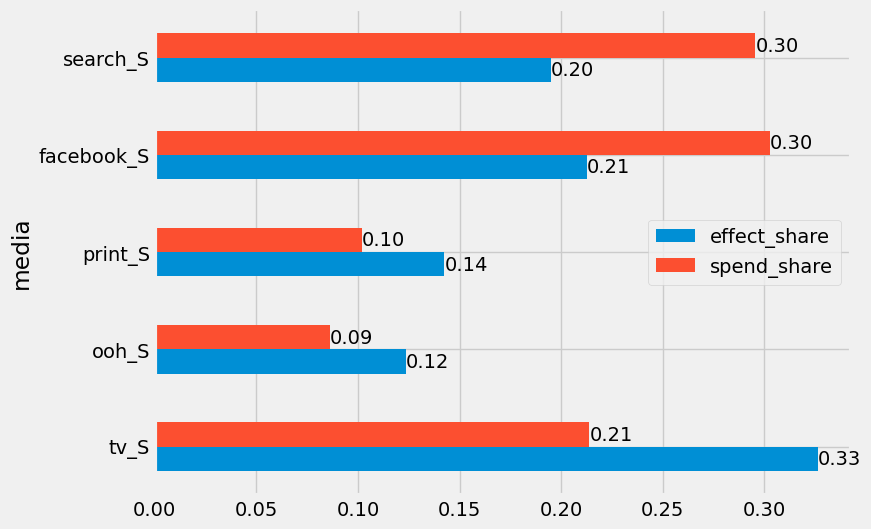

In [17]:
ax = spend_effect_share.set_index('media').plot(kind='barh', figsize=(8, 6))
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

In [7]:
spend_effect_share

,media,effect_share,spend_share
0,tv_S,0.326164,0.213826
1,ooh_S,0.123546,0.086176
2,print_S,0.142488,0.101714
3,facebook_S,0.212759,0.302747
4,search_S,0.195042,0.295537


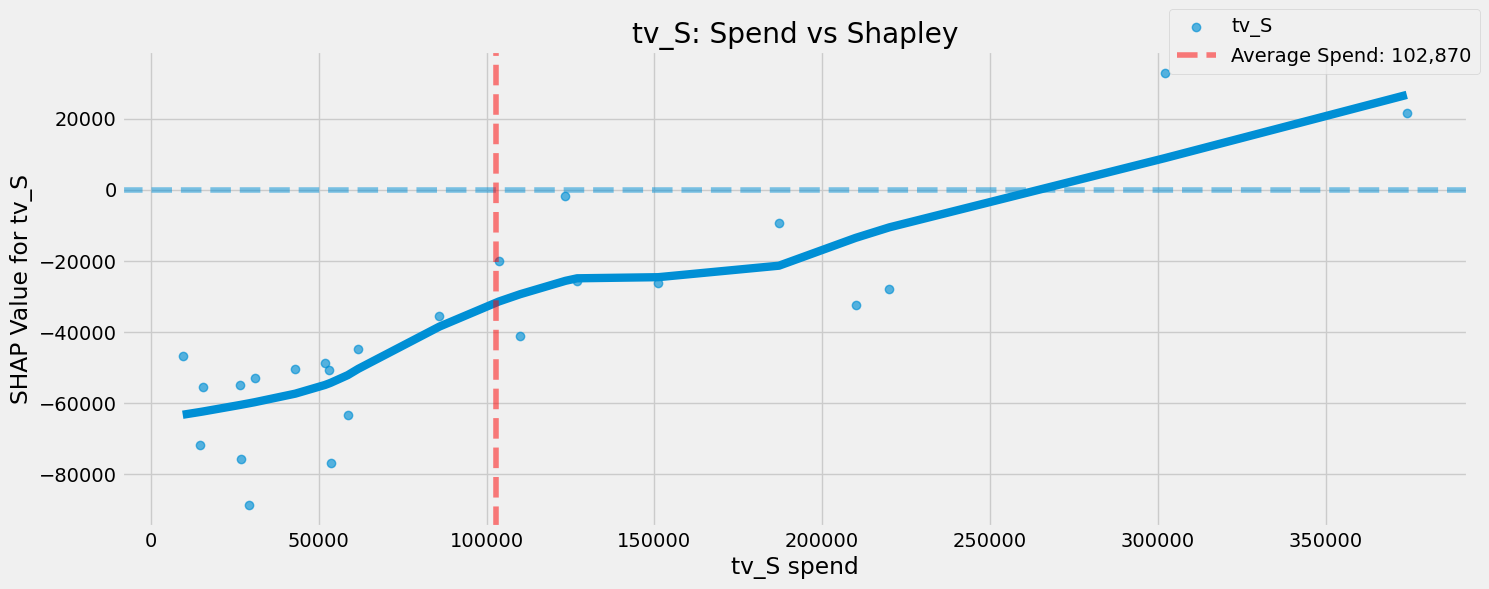

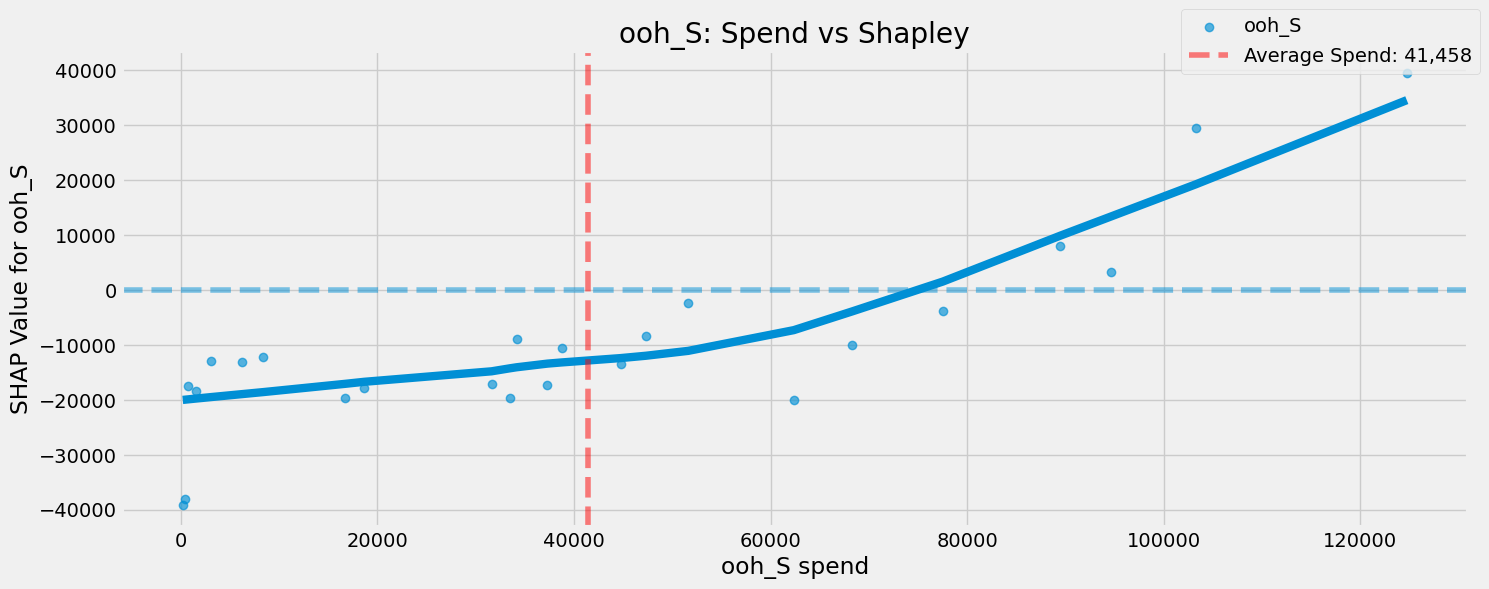

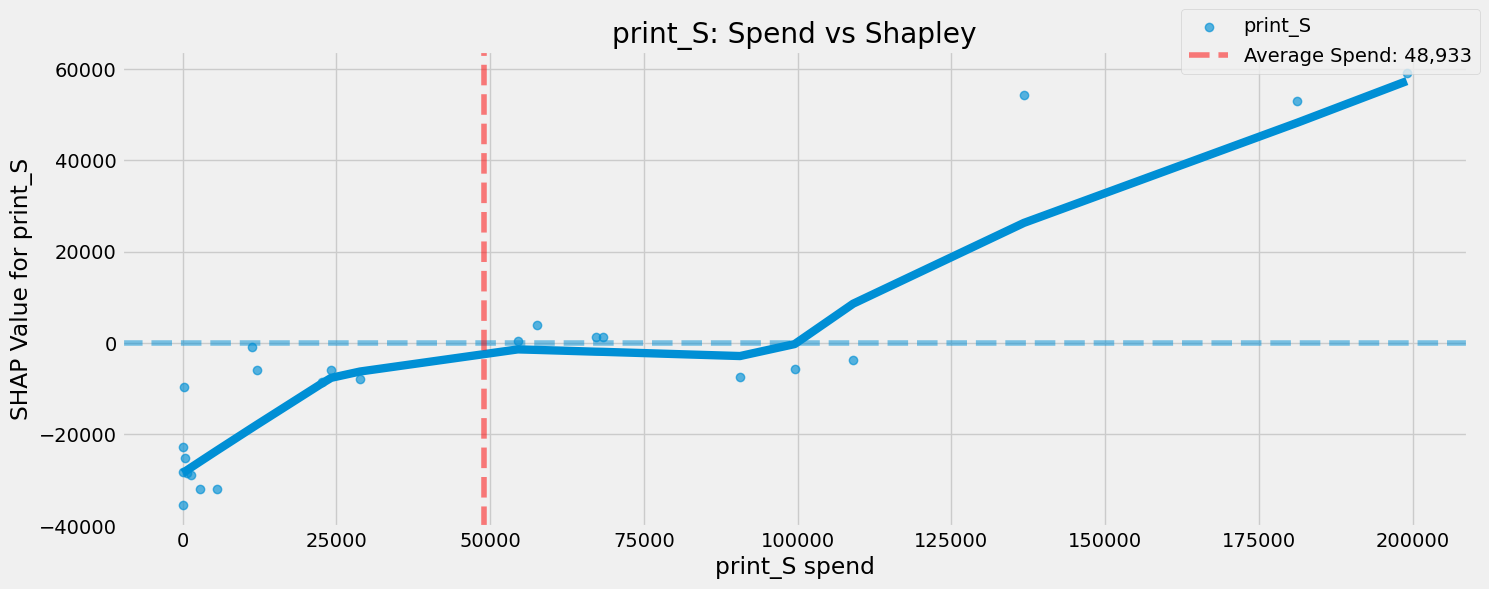

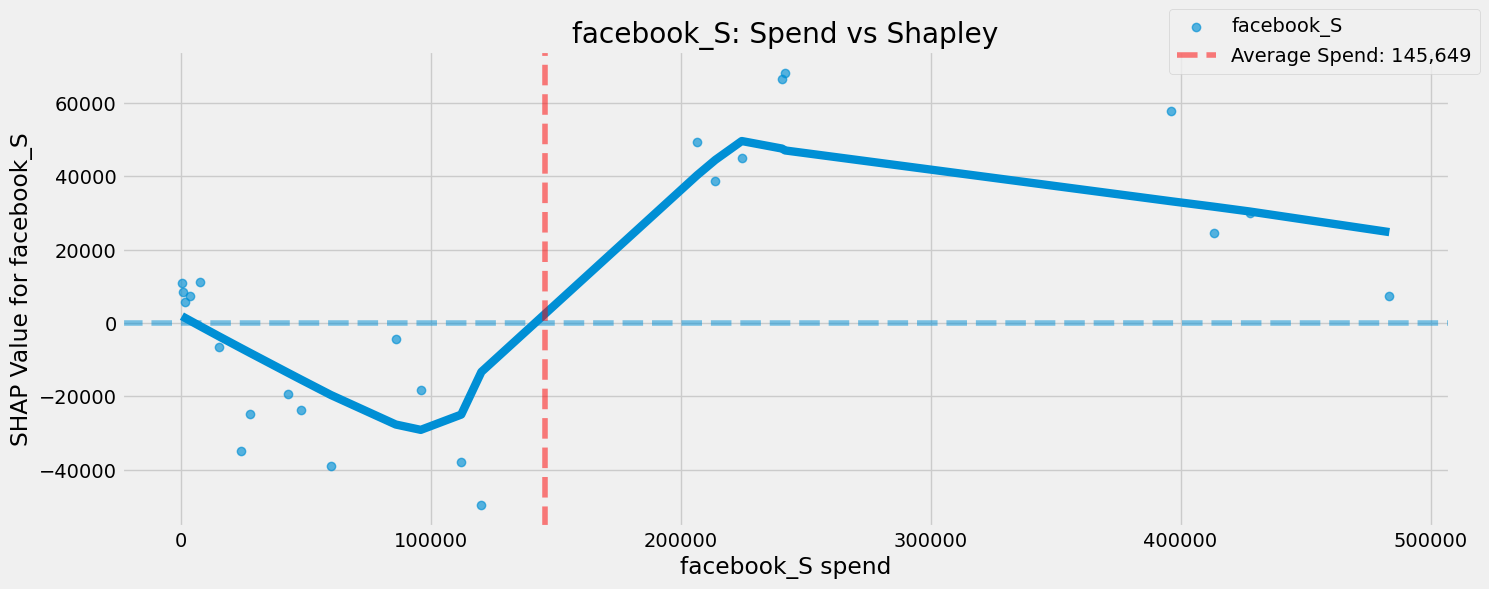

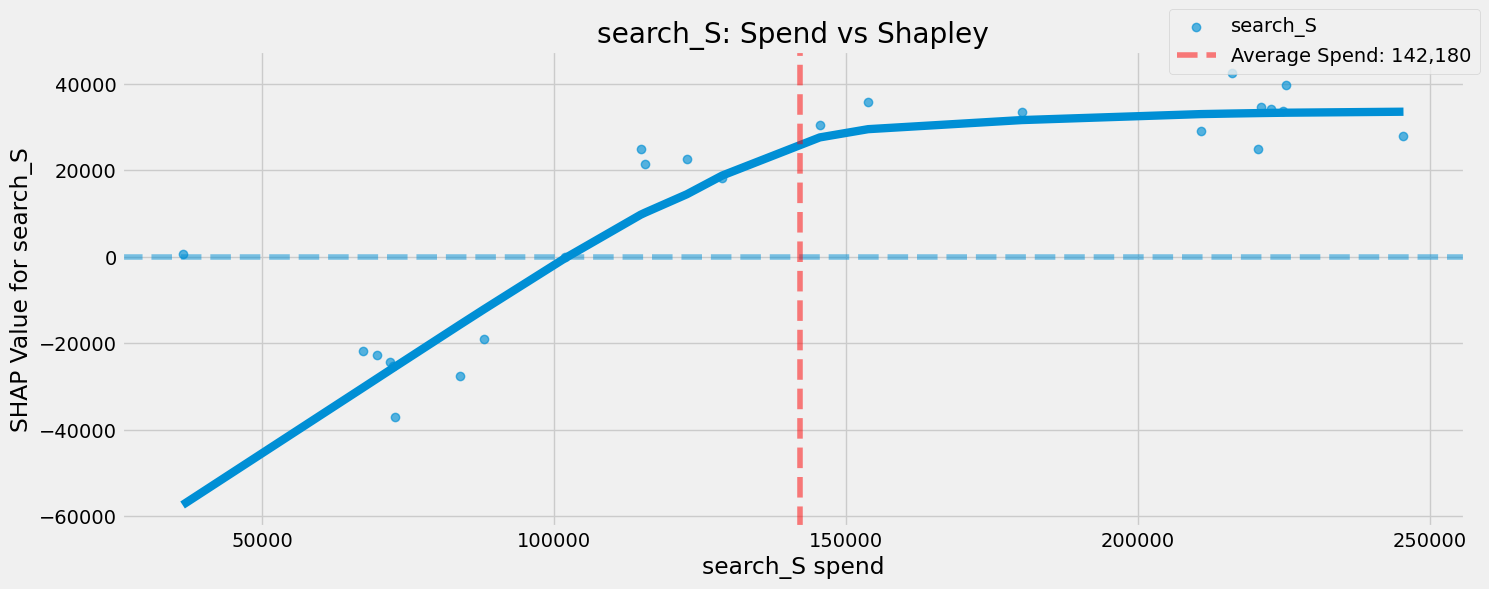

In [20]:
for channel in media_channels:
    mean_spend = x_test.loc[x_test[channel] > 0, channel].mean()
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.regplot(x=x_test[channel], y=df_shap_values[channel], scatter_kws={'alpha': 0.65}, lowess=True, ax=ax, label=channel)
    ax.set_title(f'{channel}: Spend vs Shapley')
    ax.axhline(0, linestyle = "--", alpha=0.5)
    ax.axvline(mean_spend, linestyle = "--", color="red", alpha=0.5, label=f"Average Spend: {int(mean_spend):,.0f}")
    ax.set_xlabel(f"{channel} spend")
    ax.set_ylabel(f'SHAP Value for {channel}')
    fig.legend()
    fig.tight_layout()

In [9]:
df_shap_values

,trend,yearly,holidays,competitor_sales_B,events,tv_S,ooh_S,print_S,facebook_S,search_S,newsletter
0,-40162.752486,-106505.602812,-53864.734812,-725954.317197,0.0,-63476.824341,-13115.537825,-8540.149663,-24781.781612,-25196.895241,7699.068456
1,-34492.500293,-107248.587704,418918.440541,-721468.404746,0.0,-88763.016930,-13004.833762,-937.331883,-6512.219335,-21870.591685,6618.734918
2,-39552.902362,-110464.985260,-53971.087432,-793099.373628,0.0,-71989.441682,-18367.756474,-31921.662497,11149.939165,-22721.088646,12675.097277
3,-34662.669396,-110028.675300,-53864.734812,-795715.998139,0.0,-77044.762680,-17476.982923,-31921.513086,7335.705179,-24328.163591,-303.569531
4,-46585.187675,-53502.577782,-56282.988120,-490009.554025,0.0,-75857.663116,-37989.791315,-28885.508304,5659.207795,-27598.270035,23387.136414
5,-46585.187675,-49211.457315,-56282.988120,-485726.438412,0.0,-50716.607290,-39137.187757,-28550.481529,8478.051726,-19078.823238,25767.240568
6,-20017.101422,-49543.238772,-55433.627626,-475888.188594,0.0,-54996.206721,39522.873950,-25217.517077,10848.889837,-23.174660,6558.276070
7,-31165.122292,3363.655211,-51921.205425,-472882.839215,0.0,-20062.936741,-19948.833937,-9693.541863,-4426.379692,24919.130570,28486.045303
8,-26297.910662,3092.191287,-44088.884467,-208752.869719,0.0,-48665.307628,29483.862639,-22698.434298,-19229.279863,18350.530231,-2477.970104
9,-12287.018926,3343.740334,-41775.627051,-39499.878967,0.0,-1887.945759,-2388.686381,-28214.527875,7498.693509,30615.111114,-51.626906
